In [42]:
import numpy as np
import matplotlib.pyplot as plt
import random
import simpy
import scipy.stats as st

### 1.
Using the Erlang C Formula (A. Willig, 1999), which calculates the probability of queuing we find the following:

#### M/M/2 Queue:

1. **Erlang C Formula**: 
   $$ P_w = \frac{\frac{(\rho \cdot 2)^2}{2!} \cdot \frac{1}{1 - \rho}}{\sum_{k=0}^{1} \frac{(\rho \cdot 2)^k}{k!} + \frac{(\rho \cdot 2)^2}{2!} \cdot \frac{1}{1 - \rho}} $$

2. **Average Waiting Time in Queue**:
   $$ W_q = \frac{P_w}{2\mu - \lambda} $$

3. **Total Average Time in System**:
   $$ W = W_q + \frac{1}{\mu} $$

#### M/M/1 Queue:

1. **Average Waiting Time in Queue**:
   $$ \rho' = \frac{\lambda'}{\mu} = \frac{\rho}{2} $$
   $$ W_q' = \frac{1}{\mu - \lambda'} $$

2. **Total Average Time in System**:
   $$ W' = W_q' + \frac{1}{\mu} $$

It makes sense that the queue time in a M/M/N system where $N>2$ has shorter queue times. Non-mathematically this can be thought as two supermarkets where one supermarket only has one cashier (N=1) available in comparison to the other supermarket that has two cashiers (N=2). Assuming same parameters, the supermarket with two cashiers will have higher throughput.

In [15]:
import math

def erlangC(n, rho):
    """Calculate the Erlang C formula for given n servers and system load rho."""
    numerator = (rho**n / math.factorial(n)) * (1 / (1 - rho))
    denominator = sum([(rho**k) / math.factorial(k) for k in range(n)]) + numerator
    return numerator / denominator

def mmn_queue(lambda_rate, mu, n):
    """Calculate average waiting and total time in system for M/M/n queue."""
    rho = lambda_rate / (n * mu)
    Pw = erlangC(n, rho)
    Wq = Pw / (n * mu - lambda_rate)
    return Wq, Wq + 1/mu

def mm1_queue(lambda_rate, mu):
    """Calculate average waiting and total time in system for M/M/1 queue."""
    rho = lambda_rate / mu
    Wq_prime = 1 / (mu - lambda_rate)
    return Wq_prime, Wq_prime + 1/mu

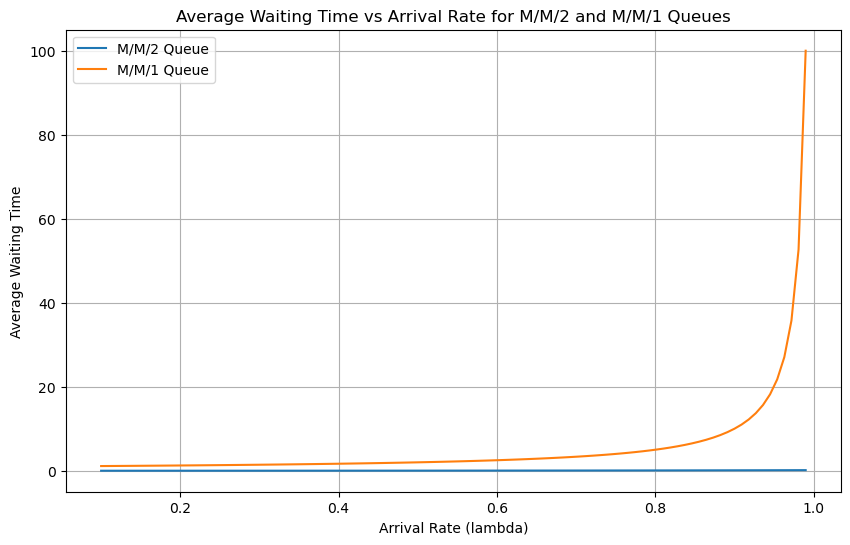

In [27]:
# Parameters
mu = 1
n = 2
lambda_rates = np.linspace(0.1, mu-0.01, 100)  # Vary lambda such that rho < 1 at all times

# Calculate waiting times for each value of lambda
waiting_times_mmn = [mmn_queue(lambda_rate, mu, n)[0] for lambda_rate in lambda_rates]
waiting_times_mm1 = [mm1_queue(lambda_rate, mu)[0] for lambda_rate in lambda_rates]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(lambda_rates, waiting_times_mmn, label='M/M/2 Queue')
plt.plot(lambda_rates, waiting_times_mm1, label='M/M/1 Queue')
plt.xlabel('Arrival Rate (lambda)')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs Arrival Rate for M/M/2 and M/M/1 Queues')
plt.legend()
plt.grid(True)
plt.show()

### 2.
Using https://simpy.readthedocs.io/en/latest/examples/bank_renege.html tutorial code as base

In [43]:
RANDOM_SEED = 42
NEW_CUSTOMERS = 200 
INTERVAL_CUSTOMERS = 10.0  # Generate new customers roughly every x seconds
SIMULATIONS = 100

def source(env, number, interval, counter, wait_times):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, f'Customer{i:02d}', counter, wait_times)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)

def customer(env, name, counter, wait_times):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    with counter.request() as req:
        results = yield req | env.timeout(12.0)  # Timeout for waiting in the queue
        wait = env.now - arrive
        if req in results:
            service_time = random.expovariate(1.0 / 12.0) 
            yield env.timeout(service_time)
            wait_times.append(wait)

# Run the simulation for different numbers of servers and collect data
wait_times_data = {1: [], 2: [], 4: []}
for num_servers in [1, 2, 4]:
    for i in range(SIMULATIONS):
        random.seed(RANDOM_SEED+i) # Same seed for reproducibility
        env = simpy.Environment()
        counter = simpy.Resource(env, capacity=num_servers)
        wait_times = []
        env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter, wait_times))
        env.run()
        wait_times_data[num_servers].append(np.mean(wait_times))

# Calculate average, standard deviation, and 95% confidence interval
for num_servers, times in wait_times_data.items():
    avg_wait_time = np.mean(times)
    std_dev = np.std(times)
    conf_interval = st.t.interval(0.95, len(times)-1, loc=avg_wait_time, scale=st.sem(times))
    print(f'Servers: {num_servers}, Average Wait Time: {avg_wait_time:.2f}, Std Dev: {std_dev:.2f}, 95% CI: {conf_interval}')


Servers: 1, Average Wait Time: 3.47, Std Dev: 0.45, 95% CI: (3.3818938515136154, 3.5603070110152575)
Servers: 2, Average Wait Time: 1.61, Std Dev: 0.38, 95% CI: (1.5358865424063302, 1.6870932057202865)
Servers: 4, Average Wait Time: 0.11, Std Dev: 0.10, 95% CI: (0.09334739941157705, 0.13385980488716515)


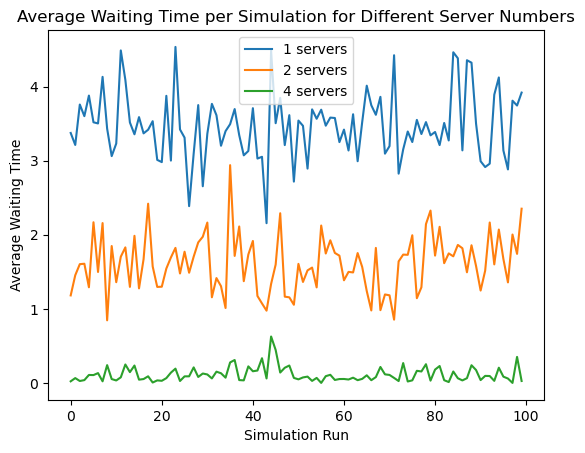

In [46]:
# Plotting average waiting times for each simulation
for num_servers, times in wait_times_data.items():
    plt.plot(times, label=f'{num_servers} servers')

plt.xlabel('Simulation Run')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time per Simulation for Different Server Numbers')
plt.legend()
plt.show()